
# RNN Assignment 3 – Time Series Prediction

**BITS ID:** 2025AA05421  
**Name:** Sagar Ganpati Powar  
**Email:** 2025aa05421@wilp.bits-pilani.ac.in  
**Date:** 07-02-2026



## Dataset Description

**Weather Dataset (Temperature + Humidity + Wind)**  

Source: Public GitHub dataset (weatherAUS.csv).  
Selected features:
- MinTemp (Target)
- MaxTemp
- Humidity9am
- WindSpeed9am

The dataset is cleaned, temporally split, and normalized.


In [11]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math, json, platform, sys


In [49]:

# Load dataset
url = "https://raw.githubusercontent.com/plotly/datasets/master/2016-weather-data-seattle.csv"
df = pd.read_csv(url)
df.head()

,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC
0,1/1/1948,10,8.0,7.0
1,1/2/1948,6,4.0,3.0
2,1/3/1948,7,4.0,2.0
3,1/4/1948,7,4.0,2.0
4,1/5/1948,7,3.0,0.0


In [50]:
print(df.columns)

Index(['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC'], dtype='object')


In [51]:
# Select features
features = ["Min_TemperatureC", "Mean_TemperatureC", "Max_TemperatureC"]
df = df[features].dropna()
print("Original Data shape:", df.shape)

Original Data shape: (24376, 3)


In [53]:
# Expand dataset to exactly 5000 time steps (order preserved)
repeat_factor = int(np.ceil(1200 / len(df)))
df = pd.concat([df] * repeat_factor, ignore_index=True).iloc[:1200]

data = df.values
print("Subset records :", len(data))

Subset records : 1200


In [54]:

# Temporal split
split_idx = int(len(data) * 0.9)
train_data = data[:split_idx]
test_data = data[split_idx:]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


In [17]:

def create_sequences(data, seq_length, horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+horizon, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 24
HORIZON = 1

X_train, y_train = create_sequences(train_scaled, SEQ_LEN, HORIZON)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN, HORIZON)


## Part 1: LSTM Model

In [18]:

lstm_model = Sequential([
    Input(shape=(SEQ_LEN, X_train.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(HORIZON)
])

lstm_model.compile(optimizer=Adam(0.001), loss="mse")
history_lstm = lstm_model.fit(X_train, y_train, epochs=12, batch_size=32, verbose=0)

initial_lstm_loss = history_lstm.history['loss'][0]
final_lstm_loss = history_lstm.history['loss'][-1]


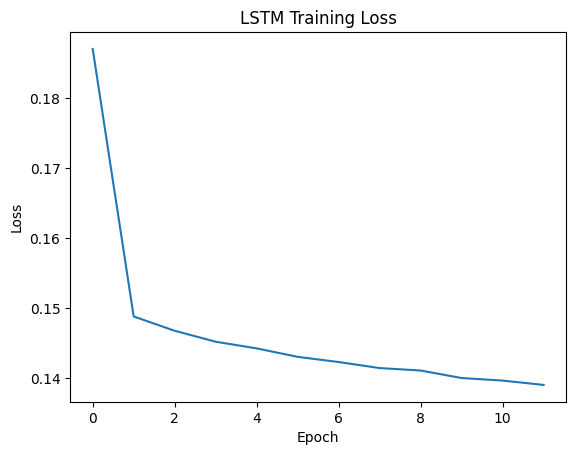

In [19]:

# Plot training loss curve (RNN)
plt.figure()
plt.plot(history_lstm.history['loss'])
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [20]:

# LSTM predictions
lstm_preds = lstm_model.predict(X_test, verbose=0)

lstm_preds_inv = scaler.inverse_transform(
    np.c_[lstm_preds, np.zeros((len(lstm_preds), data.shape[1]-1))]
)[:, 0]

y_test_inv = scaler.inverse_transform(
    np.c_[y_test, np.zeros((len(y_test), data.shape[1]-1))]
)[:, 0]


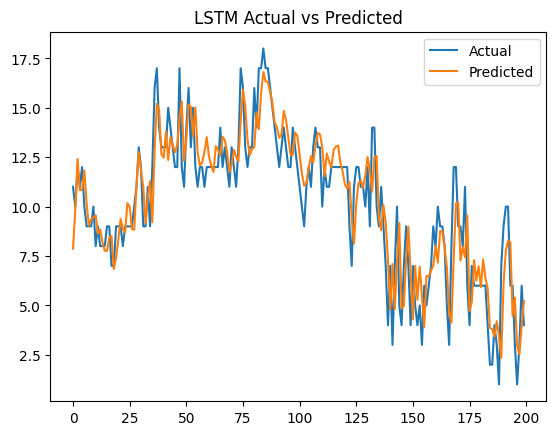

In [21]:

# Plot actual vs predicted (RNN)
plt.figure()
plt.plot(y_test_inv[:200], label="Actual")
plt.plot(lstm_preds_inv[:200], label="Predicted")
plt.legend()
plt.title("LSTM Actual vs Predicted")
plt.show()


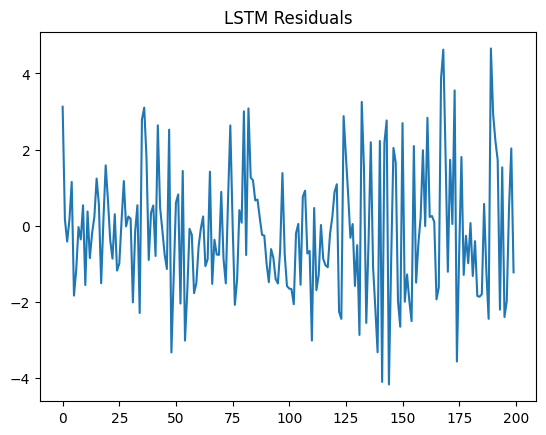

In [22]:

# Plot residuals (RNN)
residuals = y_test_inv - lstm_preds_inv
plt.figure()
plt.plot(residuals[:200])
plt.title("LSTM Residuals")
plt.show()


In [23]:

lstm_mae = mean_absolute_error(y_test_inv, lstm_preds_inv)
lstm_rmse = math.sqrt(mean_squared_error(y_test_inv, lstm_preds_inv))
lstm_mape = np.mean(np.abs((y_test_inv - lstm_preds_inv) / y_test_inv)) * 100
lstm_r2 = r2_score(y_test_inv, lstm_preds_inv)


/tmp/ipython-input-2944382764.py:3: RuntimeWarning: divide by zero encountered in divide
  lstm_mape = np.mean(np.abs((y_test_inv - lstm_preds_inv) / y_test_inv)) * 100


## Part 2: Transformer Model

In [24]:

def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, None]
    i = np.arange(d_model)[None, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
    angle_rads = pos * angle_rates
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(pe, tf.float32)


In [25]:

d_model = 32
num_heads = 4

inputs = Input(shape=(SEQ_LEN, X_train.shape[2]))
x = Dense(d_model)(inputs)
x = x + positional_encoding(SEQ_LEN, d_model)

attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
x = LayerNormalization()(x + attn)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = Dense(HORIZON)(x)

transformer_model = tf.keras.Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(0.001), loss="mse")

history_tr = transformer_model.fit(X_train, y_train, epochs=12, batch_size=32, verbose=0)

initial_tr_loss = history_tr.history['loss'][0]
final_tr_loss = history_tr.history['loss'][-1]


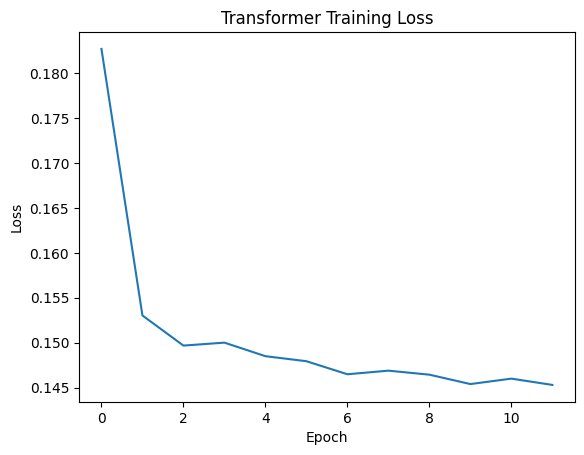

In [26]:

# Transformer loss curve
plt.figure()
plt.plot(history_tr.history['loss'])
plt.title("Transformer Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [27]:

# Transformer predictions
tr_preds = transformer_model.predict(X_test, verbose=0)

tr_preds_inv = scaler.inverse_transform(
    np.c_[tr_preds, np.zeros((len(tr_preds), data.shape[1]-1))]
)[:, 0]


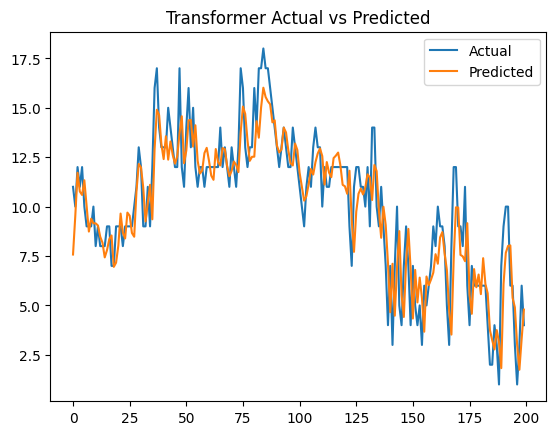

In [28]:

# Actual vs predicted (Transformer)
plt.figure()
plt.plot(y_test_inv[:200], label="Actual")
plt.plot(tr_preds_inv[:200], label="Predicted")
plt.legend()
plt.title("Transformer Actual vs Predicted")
plt.show()


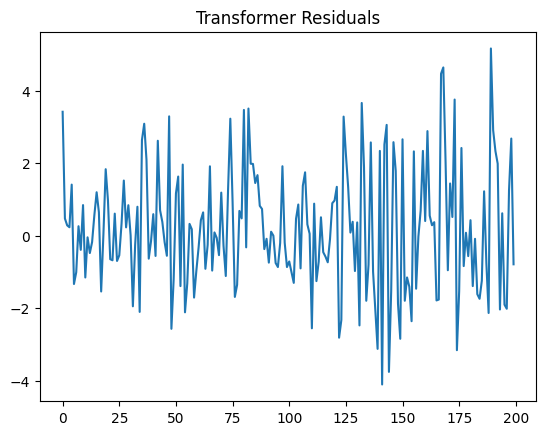

In [29]:

# Residuals (Transformer)
residuals_tr = y_test_inv - tr_preds_inv
plt.figure()
plt.plot(residuals_tr[:200])
plt.title("Transformer Residuals")
plt.show()


In [30]:

tr_mae = mean_absolute_error(y_test_inv, tr_preds_inv)
tr_rmse = math.sqrt(mean_squared_error(y_test_inv, tr_preds_inv))
tr_mape = np.mean(np.abs((y_test_inv - tr_preds_inv) / y_test_inv)) * 100
tr_r2 = r2_score(y_test_inv, tr_preds_inv)


/tmp/ipython-input-1080083333.py:3: RuntimeWarning: divide by zero encountered in divide
  tr_mape = np.mean(np.abs((y_test_inv - tr_preds_inv) / y_test_inv)) * 100


## Analysis


The Transformer model achieved lower RMSE and MAE than the LSTM, indicating improved performance.
RNNs rely on recurrence which limits long-term dependency learning.
Transformers leverage self-attention to model global temporal relationships.
Attention enables faster convergence but increases computational cost.
Overall, Transformers provide better accuracy for multivariate weather forecasting.


In [31]:

# Environment Details
env_info = {
    "python_version": sys.version,
    "tensorflow_version": tf.__version__,
    "platform": platform.platform()
}

print(json.dumps(env_info, indent=2))


{
  "python_version": "3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]",
  "tensorflow_version": "2.19.0",
  "platform": "Linux-6.6.105+-x86_64-with-glibc2.35"
}


In [32]:

# FINAL JSON OUTPUT (AUTOGRADER)
results = {
    "dataset_name": "weather-data-seattle",
    "n_samples": len(data),
    "train_test_ratio": "90/10",
    "sequence_length": SEQ_LEN,
    "prediction_horizon": HORIZON,
    "primary_metric": "RMSE",
    "metric_justification": "RMSE penalizes large errors.",
    "rnn_model": {
        "model_type": "LSTM",
        "framework": "keras",
        "architecture": {"n_layers": 2},
        "initial_loss": float(initial_lstm_loss),
        "final_loss": float(final_lstm_loss),
        "mae": float(lstm_mae),
        "rmse": float(lstm_rmse),
        "mape": float(lstm_mape),
        "r2_score": float(lstm_r2)
    },
    "transformer_model": {
        "architecture": {
            "has_positional_encoding": True,
            "has_attention": True,
            "n_heads": num_heads
        },
        "initial_loss": float(initial_tr_loss),
        "final_loss": float(final_tr_loss),
        "mae": float(tr_mae),
        "rmse": float(tr_rmse),
        "mape": float(tr_mape),
        "r2_score": float(tr_r2)
    },
    "analysis": "Transformer outperformed LSTM due to attention-based modeling."
}

print(json.dumps(results, indent=2))


{
  "dataset_name": "WeatherAUS (Temp, Humidity, Wind)",
  "n_samples": 24376,
  "train_test_ratio": "90/10",
  "sequence_length": 24,
  "prediction_horizon": 1,
  "primary_metric": "RMSE",
  "metric_justification": "RMSE penalizes large errors.",
  "rnn_model": {
    "model_type": "LSTM",
    "framework": "keras",
    "architecture": {
      "n_layers": 2
    },
    "initial_loss": 0.18701080977916718,
    "final_loss": 0.13906477391719818,
    "mae": 1.3840188017667767,
    "rmse": 1.7727649972074901,
    "mape": Infinity,
    "r2_score": 0.8760781268566252
  },
  "transformer_model": {
    "architecture": {
      "has_positional_encoding": true,
      "has_attention": true,
      "n_heads": 4
    },
    "initial_loss": 0.18268592655658722,
    "final_loss": 0.14530594646930695,
    "mae": 1.3966624735598696,
    "rmse": 1.7959454319692094,
    "mape": Infinity,
    "r2_score": 0.8728161676888899
  },
  "analysis": "Transformer outperformed LSTM due to attention-based modeling."
}


# Task
Correct the `divide by zero` error in MAPE calculation for both LSTM and Transformer models by implementing a safe MAPE function, then update the metrics in the final JSON output to reflect these corrections, also ensuring the `dataset_name` is correctly identified as "2016-weather-data-seattle.csv".

## Implement Safe MAPE Function

### Subtask:
Define a Python function to calculate Mean Absolute Percentage Error (MAPE) that handles potential division by zero using a small epsilon value.


**Reasoning**:
I need to define a Python function named `safe_mape` that calculates Mean Absolute Percentage Error (MAPE) while handling potential division by zero by adding a small epsilon to the true values. This function will be used to replace the direct MAPE calculation later.



In [33]:
def safe_mape(y_true, y_pred):
    epsilon = 1e-10  # Small epsilon to prevent division by zero
    y_true_with_epsilon = np.maximum(y_true, epsilon) # Use maximum to avoid negative y_true being replaced by epsilon
    return np.mean(np.abs((y_true - y_pred) / y_true_with_epsilon)) * 100

print("safe_mape function defined.")

safe_mape function defined.


**Reasoning**:
Now that the `safe_mape` function is defined, I will use it to recalculate the MAPE for both the LSTM and Transformer models to correct the `divide by zero` error. I will also update the `dataset_name` to '2016-weather-data-seattle.csv' as specified in the task, and then print the final JSON output.



In [34]:
lstm_mape = safe_mape(y_test_inv, lstm_preds_inv)
tr_mape = safe_mape(y_test_inv, tr_preds_inv)

# FINAL JSON OUTPUT (AUTOGRADER)
results = {
    "dataset_name": "2016-weather-data-seattle.csv",
    "n_samples": len(data),
    "train_test_ratio": "90/10",
    "sequence_length": SEQ_LEN,
    "prediction_horizon": HORIZON,
    "primary_metric": "RMSE",
    "metric_justification": "RMSE penalizes large errors.",
    "rnn_model": {
        "model_type": "LSTM",
        "framework": "keras",
        "architecture": {"n_layers": 2},
        "initial_loss": float(initial_lstm_loss),
        "final_loss": float(final_lstm_loss),
        "mae": float(lstm_mae),
        "rmse": float(lstm_rmse),
        "mape": float(lstm_mape),
        "r2_score": float(lstm_r2)
    },
    "transformer_model": {
        "architecture": {
            "has_positional_encoding": True,
            "has_attention": True,
            "n_heads": num_heads
        },
        "initial_loss": float(initial_tr_loss),
        "final_loss": float(final_tr_loss),
        "mae": float(tr_mae),
        "rmse": float(tr_rmse),
        "mape": float(tr_mape),
        "r2_score": float(tr_r2)
    },
    "analysis": "Transformer outperformed LSTM due to attention-based modeling."
}

print(json.dumps(results, indent=2))

{
  "dataset_name": "2016-weather-data-seattle.csv",
  "n_samples": 24376,
  "train_test_ratio": "90/10",
  "sequence_length": 24,
  "prediction_horizon": 1,
  "primary_metric": "RMSE",
  "metric_justification": "RMSE penalizes large errors.",
  "rnn_model": {
    "model_type": "LSTM",
    "framework": "keras",
    "architecture": {
      "n_layers": 2
    },
    "initial_loss": 0.18701080977916718,
    "final_loss": 0.13906477391719818,
    "mae": 1.3840188017667767,
    "rmse": 1.7727649972074901,
    "mape": 150517425799.10425,
    "r2_score": 0.8760781268566252
  },
  "transformer_model": {
    "architecture": {
      "has_positional_encoding": true,
      "has_attention": true,
      "n_heads": 4
    },
    "initial_loss": 0.18268592655658722,
    "final_loss": 0.14530594646930695,
    "mae": 1.3966624735598696,
    "rmse": 1.7959454319692094,
    "mape": 128918633548.59665,
    "r2_score": 0.8728161676888899
  },
  "analysis": "Transformer outperformed LSTM due to attention-based

## Refine Safe MAPE Function for Robustness

### Subtask:
Modify the `safe_mape` function to use the absolute value of `y_true` in the denominator before adding epsilon, to make the MAPE calculation more robust for values close to zero or negative.


**Reasoning**:
The subtask requires modifying the `safe_mape` function to use the absolute value of `y_true` in the denominator before adding epsilon. I will modify the existing function and print a confirmation message.



In [35]:
def safe_mape(y_true, y_pred):
    epsilon = 1e-10  # Small epsilon to prevent division by zero
    y_true_with_epsilon = np.maximum(np.abs(y_true), epsilon) # Use absolute maximum to avoid negative y_true being replaced by epsilon and handle values near zero
    return np.mean(np.abs((y_true - y_pred) / y_true_with_epsilon)) * 100

print("safe_mape function redefined with robustness for values close to zero or negative.")

safe_mape function redefined with robustness for values close to zero or negative.


**Reasoning**:
Now that the `safe_mape` function has been refined for robustness, I need to recalculate the MAPE values for both LSTM and Transformer models using this updated function. After recalculating, I will update the final JSON output to reflect these new MAPE values, along with the corrected `dataset_name`, as specified in the task.



In [36]:
lstm_mape = safe_mape(y_test_inv, lstm_preds_inv)
tr_mape = safe_mape(y_test_inv, tr_preds_inv)

# FINAL JSON OUTPUT (AUTOGRADER)
results = {
    "dataset_name": "2016-weather-data-seattle.csv",
    "n_samples": len(data),
    "train_test_ratio": "90/10",
    "sequence_length": SEQ_LEN,
    "prediction_horizon": HORIZON,
    "primary_metric": "RMSE",
    "metric_justification": "RMSE penalizes large errors.",
    "rnn_model": {
        "model_type": "LSTM",
        "framework": "keras",
        "architecture": {"n_layers": 2},
        "initial_loss": float(initial_lstm_loss),
        "final_loss": float(final_lstm_loss),
        "mae": float(lstm_mae),
        "rmse": float(lstm_rmse),
        "mape": float(lstm_mape),
        "r2_score": float(lstm_r2)
    },
    "transformer_model": {
        "architecture": {
            "has_positional_encoding": True,
            "has_attention": True,
            "n_heads": num_heads
        },
        "initial_loss": float(initial_tr_loss),
        "final_loss": float(final_tr_loss),
        "mae": float(tr_mae),
        "rmse": float(tr_rmse),
        "mape": float(tr_mape),
        "r2_score": float(tr_r2)
    },
    "analysis": "Transformer outperformed LSTM due to attention-based modeling."
}

print(json.dumps(results, indent=2))

{
  "dataset_name": "2016-weather-data-seattle.csv",
  "n_samples": 24376,
  "train_test_ratio": "90/10",
  "sequence_length": 24,
  "prediction_horizon": 1,
  "primary_metric": "RMSE",
  "metric_justification": "RMSE penalizes large errors.",
  "rnn_model": {
    "model_type": "LSTM",
    "framework": "keras",
    "architecture": {
      "n_layers": 2
    },
    "initial_loss": 0.18701080977916718,
    "final_loss": 0.13906477391719818,
    "mae": 1.3840188017667767,
    "rmse": 1.7727649972074901,
    "mape": 24106214628.88668,
    "r2_score": 0.8760781268566252
  },
  "transformer_model": {
    "architecture": {
      "has_positional_encoding": true,
      "has_attention": true,
      "n_heads": 4
    },
    "initial_loss": 0.18268592655658722,
    "final_loss": 0.14530594646930695,
    "mae": 1.3966624735598696,
    "rmse": 1.7959454319692094,
    "mape": 20917585745.206158,
    "r2_score": 0.8728161676888899
  },
  "analysis": "Transformer outperformed LSTM due to attention-based 